# A web-ready and 5G-ready volumetric video streaming platform: a platform prototype and empirical study

This notebook accompanies a paper presenting an updated web- and 5G-compatible platform for live volumetric video streaming. It demonstrates real-time transmission and rendering of point-cloud data (PLY/Draco) over WebSocket and HTTP/DASH, and reports on an empirical evaluation of browser and device performance under varied network conditions and transport protocols.

This jupyter notebook was created using `Python3.10.12` requires the libraries:
```
- Pandas==2.2.3
- Numpy==2.2.0
- Seaborn==0.13.2
- Matplotlib==3.9.3
```
- Additionally: `utils.py` has to be in the same folder level

# 1. Filter and format data 
### (This section can be ignored as the processed dataset exists already `all.csv`)

This initial section handles the raw datasets collected from both WebSockets and MPD series of experiments and executes data cleaning to provide a unified dataframe for the analysis. If `all.csv` file is present in `./experiments/processed/` this section can be ignored and you can consider only from section 2.

In [1]:
import pandas as pd
from numpy import nan, inf
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from utils import load_mpd_experiments

# Loading MPD experiments
df_mpd = load_mpd_experiments(root_dir='./experiments/raw/')

# Load and parse test name into conditions
websocket_path = './experiments/raw/int/ws/wifi_ws_mobil_&_gaming.csv'
df_ws = pd.read_csv(websocket_path, dtype=str, na_values=['nan', 'undefined'])

Adding columns for the MPD experiments

In [ ]:
df_mpd['Device Name'] = df_mpd['Device Name'].str.replace(' ', '')

df_mpd['experiment_group'] = (
    df_mpd['Device Name']
    + '_' 
    + df_mpd['Concurrent'].apply(lambda x: 'Concurrent' if x else 'Isolated') 
    + '_' 
    + df_mpd['Network']
    + '_'
    + df_mpd['Transport']
    + '_'
    + df_mpd['Testbed']
)
df_mpd['points_label'] = df_mpd['Test Name'].apply(lambda x: x.split('-')[-1])
df_mpd['fps_label'] = df_mpd['Test Name'].apply(lambda x: x.split('-')[-2])

Adding and formating columns for WS experiments. Then all the columns are in the same format for both transport methods

In [ ]:
# Parse test name into conditions
df_ws['Concurrent'] = df_ws['Test Name'].str.contains('both')
df_ws['Test Name'] = df_ws['Test Name'].str.replace('both_mobile', 'HuaweiNova6')
df_ws['Test Name'] = df_ws['Test Name'].str.replace('both_gaming', 'Laptop')
df_ws['Test Name'] = df_ws['Test Name'].str.replace('gaming_laptop', 'Laptop')
df_ws['Test Name'] = df_ws['Test Name'].str.replace('5GMobile', 'HuaweiNova6')

df_ws['Test Name'] = df_ws['Test Name'].str.replace('Julen', 'ds0_celo-playing_TEST_DATASET')
df_ws[['Device Name', 'seq_id', 'seq_name', 'test','dataset','points_label','fps_label', 'run', 'date', 'time']] = df_ws['Test Name'].str.split('_', expand=True)
df_ws['Network'] = 'Wifi'
df_ws['Transport'] = 'ws'
df_ws['Testbed'] = 'int'

if 'Compressed' in df_ws.columns:
    df_ws.drop(columns=['Compressed'], inplace=True) # Drop not used column

df_ws['experiment_group'] = (df_ws['Device Name'] 
    + '_' 
    + df_ws['Concurrent'].apply(lambda x: 'Concurrent' if x else 'Isolated') 
    + '_' 
    + df_ws['Network']
    + '_ws_int'
)

df_ws.drop(columns=['seq_id', 'seq_name', 'test','dataset','run', 'date', 'time'], inplace=True)

Merging both datasets in a single one

In [ ]:
df = pd.concat([df_ws, df_mpd], ignore_index=True)

Removing invalid tests with duplicates in frame number

In [ ]:
# Deleting experiments that are problematic (repeated frames)

# Group by device, fps, and points
grouped = df.groupby(['experiment_group','fps_label', 'points_label'], observed=True)

# Count the number of duplicates in 'Frame Number' within each group
duplicate_counts = grouped.apply(lambda group: group['Frame Number'].duplicated().sum(), include_groups=False)

# Reset the index to make it easier to read
duplicate_counts = duplicate_counts.reset_index(name='duplicate_count')

invalid_tests = duplicate_counts[duplicate_counts['duplicate_count'] > 0]

print(f'Number of invalid tests: {len(invalid_tests)}:')
for _, test in invalid_tests.iterrows():
    print(f"  - {test['experiment_group']} - {test['fps_label']} - {test['points_label']}: {test['duplicate_count']} duplicates")

for _, test in invalid_tests.iterrows():
    df.drop(df[(df['experiment_group'] == test['experiment_group']) & 
               (df['fps_label'] == test['fps_label']) & 
               (df['points_label'] == test['points_label'])].index, inplace=True)

df.reset_index(drop=True, inplace=True)

Removing invalid rows. For each experiment, the first row was "undefined", this row is removed for every experiment

In [ ]:
df_with_nan = len(df[df['Frame Number'].isna()])
print('Number of rows removed:', df_with_nan)

# Filter out rows with NaN in 'Test Name' or 'Frame Number'
df = df[df['Test Name'].notna()]
df = df[df['Frame Number'].notna()]

### Experiments group summary

In [ ]:
# Group by 'Device Name', 'Concurrent', 'Network', and 'data_trans'
grouped_df = df.groupby(['Device Name', 'Concurrent', 'Network', 'Transport', 'Testbed'])

# Show all groups
for i, name in enumerate(grouped_df):
    print(f"Group {i+1}: {name[0]}")

## Adding nice labels

Converting fps and points columns to `category` instead of `str`

In [ ]:
# Create nice labels for plotting
df['fps_label'] = df['fps_label'].str.replace('-', '')
df['fps_label'] = df['fps_label'].str.replace('fps', '')
df['fps_label'] = df['fps_label'].str.replace('05', '5')
df.loc[:,'fps'] = pd.Categorical(df.fps_label, categories=df['fps_label'].unique(), ordered=True)

In [ ]:
# Create nice labels for plotting
df['points_label'] = df['points_label'].str.replace('points-', '')
df['points_label'] = df['points_label'].str.replace('05', '5')
df['points_label'] = df['points_label'].str.replace('08', '8')
df['points_label'] = df['points_label'].str.replace('00000', '00K')
df['points_label'] = df['points_label'].str.replace('0000', '0K')
df.loc[:,'points'] = pd.Categorical(df.points_label, categories=df['points_label'].unique(), ordered=True)

Creating a column named `experiment_id`, which contains the specific condition of the test considering:
- device name
- concurrency
- network
- transport method
- testbed
- fps
- number of points

In [ ]:
df["Timestamp"] = df["Timestamp"].astype(int)

df['experiment_id'] = df['experiment_group'] + '_' + df['fps'].astype(str) + '_' + df['points'].astype(str)

In [ ]:
# Drop unnecessary columns
df.drop(columns=['Test Name', 'points_label', 'fps_label'], inplace=True)

Formating columns' names, resorting columns order, making it lowercase and removing spaces

In [ ]:
first_columns = ['Device Name', 'Concurrent', 'Network', 'Transport', 'Testbed', 'fps', 'points']
df = df[first_columns + [col for col in df.columns if col not in first_columns]]

columns_lower = df.columns.str.lower()
df.columns = columns_lower
df.columns = df.columns.str.replace(' ', '_')

In [ ]:
df['frame_number'] = df.groupby('experiment_id').cumcount().astype(int) # Correcting frame number for each experiment. WS experiments did not have frame number as 0, 1, 2, 3, etc.

Replacing NaN to "" in the buffers' timestamps of WS. As this method does not use buffers, NaN will cause causing calculations problems on these columns, leaving it as an empty entry won't.

In [ ]:
df.loc[df['transport'] == 'ws'] = df.loc[df['transport'] == 'ws'].replace(nan, '')

Saving processed datasets

In [ ]:
df[df['transport'] == 'ws'].to_csv('./experiments/processed/ws.csv', index=False)
df[df['transport'] == 'mpd'].to_csv('./experiments/processed/mpd.csv', index=False)
df.to_csv('./experiments/processed/all.csv', index=False)

# 2. Experiment anlysis
### Analysis starts here loading the dataset from `all.csv`

In [74]:
import pandas as pd
from numpy import nan, inf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [75]:
df = pd.read_csv('./experiments/processed/all.csv')

### Dataset statistics

#### 1. Number of experiments

In [76]:
n_exps = df['experiment_id'].nunique()
print(f'Number of experiments: {n_exps}')

Number of experiments: 324


#### 2. Experiment total size

In [77]:
number_of_points = df['points'].unique()
number_of_points = sorted(list(map(lambda x: int(x[:-1]), number_of_points)))
number_of_points = list(map(lambda x: str(x)+'K', number_of_points))
for p in number_of_points:
    sub_df_points = df[df['points'] == p]
    print(f"Number of points: {p}, Avg frame size: {sub_df_points['frame_bytes'].mean() / (1024):.2f} ± {sub_df_points['frame_bytes'].std() / (1024):.2f} Kb")

Number of points: 50K, Avg frame size: 146.22 ± 1.22 Kb
Number of points: 80K, Avg frame size: 219.41 ± 1.93 Kb
Number of points: 150K, Avg frame size: 374.46 ± 3.88 Kb
Number of points: 200K, Avg frame size: 476.65 ± 5.20 Kb
Number of points: 300K, Avg frame size: 666.84 ± 7.83 Kb
Number of points: 500K, Avg frame size: 1010.46 ± 13.43 Kb


### 3. Numer of experiments and number of row per each condition

In [78]:
experiment_conditions = ['device_name', 'concurrent', 'network', 'transport', 'testbed', 'fps', 'points']

for condition in experiment_conditions:
    print(f"Experiments by {condition}:")
    parameter_values = df[condition].unique()
    for p in parameter_values:
        n_exps = df[df[condition] == p]['experiment_id'].nunique()
        n_rows = len(df[df[condition] == p])
        print(f"  - {p}: {n_exps} experiments, {n_rows} rows in total")

Experiments by device_name:
  - Laptop: 179 experiments, 214833 rows in total
  - HuaweiNova6: 145 experiments, 173214 rows in total
Experiments by concurrent:
  - False: 167 experiments, 200817 rows in total
  - True: 157 experiments, 187230 rows in total
Experiments by network:
  - Wifi: 163 experiments, 168294 rows in total
  - 5G: 161 experiments, 219753 rows in total
Experiments by transport:
  - ws: 79 experiments, 53279 rows in total
  - mpd: 245 experiments, 334768 rows in total
Experiments by testbed:
  - int: 242 experiments, 276685 rows in total
  - ext: 82 experiments, 111362 rows in total
Experiments by fps:
  - 5: 87 experiments, 99156 rows in total
  - 10: 88 experiments, 100390 rows in total
  - 15: 82 experiments, 97786 rows in total
  - 30: 67 experiments, 90715 rows in total
Experiments by points:
  - 50K: 64 experiments, 78120 rows in total
  - 80K: 64 experiments, 76949 rows in total
  - 150K: 62 experiments, 75520 rows in total
  - 200K: 58 experiments, 67780 rows

### Fixing experiment interval

Experiment interval is fixed in 45 seconds to avoid distorsion, counting from the playing time of the first frame

In [10]:
experiment_interval = 45 # seconds

In [11]:
df['rc_timestamp'] = df['rc_timestamp'].astype(int)
df['dc_timestamp'] = df['dc_timestamp'].astype(int)
df['pl_timestamp'] = df['pl_timestamp'].astype(int)
df['timestamp'] = df['timestamp'].astype(int)

df = (
    df.groupby("experiment_id")
    .apply(lambda group: group.loc[group["pl_timestamp"] <= group["pl_timestamp"].min() + experiment_interval*1000, group.columns != "experiment_id"], include_groups=False)
)
df["experiment_id"] = df.index.get_level_values("experiment_id")
df.reset_index(drop=True, inplace=True)

Let $t_{\mathrm{ideal}}(N)$ be the ideal playing timestamp (ms) of frame N and fps the frames-per-second.

One-based indexing (N = 1,2,...):
$$
t_{\mathrm{ideal}}(N)=t_{\mathrm{real}}(1)+(N-1)\cdot\frac{1000}{fps}
$$

In [12]:
def _make_ideal(group):
    start = group['pl_timestamp'].iloc[0]
    fps = group['fps'].iloc[0]
    interval_ms = 1000.0 / fps
    ideal = [int(round(start + i * interval_ms)) for i in range(len(group))]
    g = group.copy()
    g['ideal_pl_timestamp'] = ideal
    return g
# pass include_groups=False to silence the FutureWarning
df = df.groupby('experiment_id', sort=False).apply(_make_ideal, include_groups=False)
df["experiment_id"] = df.index.get_level_values("experiment_id") # Reinsert experiment_id column
df.reset_index(drop=True, inplace=True)
df = pd.DataFrame(df) # Fixing highlighting

In [13]:
def _normalize_timestamp(group:pd.DataFrame):
    timestamps = group.columns.str.endswith("timestamp")
    timestamps = group.columns[timestamps]
    for t in timestamps:
        starting_point = group['pl_timestamp'].min()
        norm_t = 'norm_' + t
        group[norm_t] = group[t] - starting_point 
    return group

df = df.groupby('experiment_id', sort=False).apply(_normalize_timestamp, include_groups=False)
df["experiment_id"] = df.index.get_level_values("experiment_id") # Reinsert experiment_id column
df.reset_index(drop=True, inplace=True)

### Experiment summary

In [12]:
# Frames Delivered in each condition
nframes = df.groupby(['experiment_id'], observed=True)['frame_number'].count().reset_index()

In [13]:
nframes['device_name'] = nframes['experiment_id'].str.split('_').str[0]
nframes['concurrency'] = nframes['experiment_id'].str.split('_').str[1]
nframes['network'] = nframes['experiment_id'].str.split('_').str[2]
nframes['transport'] = nframes['experiment_id'].str.split('_').str[3]
nframes['testbed'] = nframes['experiment_id'].str.split('_').str[4]
nframes['fps'] = nframes['experiment_id'].str.split('_').str[5]
nframes['points'] = nframes['experiment_id'].str.split('_').str[6]
nframes['experiment_group'] = (nframes['experiment_id'].str.split('_').str[0:-2]).str.join('_')

In [14]:
nframes

,experiment_id,frame_number,device_name,concurrency,network,transport,testbed,fps,points,experiment_group
0,HuaweiNova6_Concurrent_5G_mpd_ext_10_150K,425,HuaweiNova6,Concurrent,5G,mpd,ext,10,150K,HuaweiNova6_Concurrent_5G_mpd_ext
1,HuaweiNova6_Concurrent_5G_mpd_ext_10_200K,423,HuaweiNova6,Concurrent,5G,mpd,ext,10,200K,HuaweiNova6_Concurrent_5G_mpd_ext
2,HuaweiNova6_Concurrent_5G_mpd_ext_10_300K,82,HuaweiNova6,Concurrent,5G,mpd,ext,10,300K,HuaweiNova6_Concurrent_5G_mpd_ext
3,HuaweiNova6_Concurrent_5G_mpd_ext_10_50K,445,HuaweiNova6,Concurrent,5G,mpd,ext,10,50K,HuaweiNova6_Concurrent_5G_mpd_ext
4,HuaweiNova6_Concurrent_5G_mpd_ext_10_80K,440,HuaweiNova6,Concurrent,5G,mpd,ext,10,80K,HuaweiNova6_Concurrent_5G_mpd_ext
...,...,...,...,...,...,...,...,...,...,...
319,Laptop_Isolated_Wifi_ws_int_5_200K,225,Laptop,Isolated,Wifi,ws,int,5,200K,Laptop_Isolated_Wifi_ws_int
320,Laptop_Isolated_Wifi_ws_int_5_300K,225,Laptop,Isolated,Wifi,ws,int,5,300K,Laptop_Isolated_Wifi_ws_int
321,Laptop_Isolated_Wifi_ws_int_5_500K,221,Laptop,Isolated,Wifi,ws,int,5,500K,Laptop_Isolated_Wifi_ws_int
322,Laptop_Isolated_Wifi_ws_int_5_50K,221,Laptop,Isolated,Wifi,ws,int,5,50K,Laptop_Isolated_Wifi_ws_int


In [15]:
# Calculate ratio of frames delivered
frames_perseq = {
    '5':int(5*experiment_interval), # 225 frames in total for 45 seconds video
    '10':int(10*experiment_interval), # 450 frames in total for 45 seconds video
    '15':int(15*experiment_interval), # 675 frames in total for 45 seconds video
    '30':int(30*experiment_interval) # 1350 frames in total for 45 seconds video
}
nframes['ratio'] = nframes.apply(lambda r: (r['frame_number'])/frames_perseq[r['fps']], axis=1) 
# nframes['ratio'] = nframes['ratio'].apply(lambda x: round(x, 2)) # Round to 2 decimal places

In [16]:
nframes

,experiment_id,frame_number,device_name,concurrency,network,transport,testbed,fps,points,experiment_group,ratio
0,HuaweiNova6_Concurrent_5G_mpd_ext_10_150K,425,HuaweiNova6,Concurrent,5G,mpd,ext,10,150K,HuaweiNova6_Concurrent_5G_mpd_ext,0.944444
1,HuaweiNova6_Concurrent_5G_mpd_ext_10_200K,423,HuaweiNova6,Concurrent,5G,mpd,ext,10,200K,HuaweiNova6_Concurrent_5G_mpd_ext,0.940000
2,HuaweiNova6_Concurrent_5G_mpd_ext_10_300K,82,HuaweiNova6,Concurrent,5G,mpd,ext,10,300K,HuaweiNova6_Concurrent_5G_mpd_ext,0.182222
3,HuaweiNova6_Concurrent_5G_mpd_ext_10_50K,445,HuaweiNova6,Concurrent,5G,mpd,ext,10,50K,HuaweiNova6_Concurrent_5G_mpd_ext,0.988889
4,HuaweiNova6_Concurrent_5G_mpd_ext_10_80K,440,HuaweiNova6,Concurrent,5G,mpd,ext,10,80K,HuaweiNova6_Concurrent_5G_mpd_ext,0.977778
...,...,...,...,...,...,...,...,...,...,...,...
319,Laptop_Isolated_Wifi_ws_int_5_200K,225,Laptop,Isolated,Wifi,ws,int,5,200K,Laptop_Isolated_Wifi_ws_int,1.000000
320,Laptop_Isolated_Wifi_ws_int_5_300K,225,Laptop,Isolated,Wifi,ws,int,5,300K,Laptop_Isolated_Wifi_ws_int,1.000000
321,Laptop_Isolated_Wifi_ws_int_5_500K,221,Laptop,Isolated,Wifi,ws,int,5,500K,Laptop_Isolated_Wifi_ws_int,0.982222
322,Laptop_Isolated_Wifi_ws_int_5_50K,221,Laptop,Isolated,Wifi,ws,int,5,50K,Laptop_Isolated_Wifi_ws_int,0.982222


In [17]:
# Group by device and count the number of items that ratio is below .98, below .9, and below .8
grouped_counts = nframes.groupby('experiment_group').apply(lambda x: pd.Series({
    'exp_total': x['ratio'].count(),
    'below98': (x['ratio'] < 0.98).sum(),
    'below90': (x['ratio'] < 0.9).sum(),
    'below80': (x['ratio'] < 0.8).sum()
}), include_groups=False).reset_index()

# Replace NaN with 0
grouped_counts.fillna(0, inplace=True)

In [18]:
ratio_threshold = .80 # Using this threshold to calculate the decoding and rendering times

In [19]:
nframes['invalid'] = nframes['ratio'] < ratio_threshold
invalid_tests = list(nframes[nframes['invalid']]['experiment_id'])

### Calculations

In [20]:
buffer_size = 100
df['frame_number'] = df['frame_number'].astype(int)
df['steady_state'] = (df['frame_number'] > buffer_size) | (df['transport'] == 'ws') # WS does not have transient state

In [21]:
# Calculate times
df['total_time'] = df['pl_timestamp'].astype('float') - df['timestamp'].astype('float')
df['render_time'] = df['pl_timestamp'].astype('float') - df['dc_timestamp'].astype('float')
df['decoding_time'] = df['dc_timestamp'].astype('float') - df['rc_timestamp'].astype('float')
df['request_time'] = df['rc_timestamp'].astype('float') - df['timestamp'].astype('float')

Calculating the average and standard deviation for the decoding and redering part of the pipeline

In [22]:
# Calculate the average and standard deviation for the decoding time considering only steady_state, grouped by experiment
steady_state_df = df[(df['steady_state'] == True) & (df['experiment_id'].isin(invalid_tests) == False)]

grouped_decode_ss = steady_state_df.groupby('experiment_group')['decoding_time'].agg(['mean', 'std']).reset_index()

grouped_decode_ss['device'] = grouped_decode_ss['experiment_group'].apply(lambda x: x.split('_')[0])
grouped_decode_ss['concurrency'] = grouped_decode_ss['experiment_group'].apply(lambda x: x.split('_')[1])
grouped_decode_ss['testbed'] = grouped_decode_ss['experiment_group'].apply(lambda x: x.split('_')[-1])
grouped_decode_ss['transport'] = grouped_decode_ss['experiment_group'].apply(lambda x: x.split('_')[-2])
grouped_decode_ss['network'] = grouped_decode_ss['experiment_group'].apply(lambda x: x.split('_')[-3])
grouped_decode_ss.rename(columns={'mean': 'dec_ss_mean', 'std': 'dec_ss_std'}, inplace=True)
grouped_decode_ss['dec_ss_mean'] = grouped_decode_ss['dec_ss_mean'].astype(float).round(2)
grouped_decode_ss['dec_ss_std'] = grouped_decode_ss['dec_ss_std'].astype(float).round(2)

grouped_render_ss = steady_state_df.groupby('experiment_group')['render_time'].agg(['mean', 'std']).reset_index()
grouped_render_ss.rename(columns={'mean': 'ren_ss_mean', 'std': 'ren_ss_std'}, inplace=True)
grouped_render_ss['ren_ss_mean'] = grouped_render_ss['ren_ss_mean'].astype(float).round(2)
grouped_render_ss['ren_ss_std'] = grouped_render_ss['ren_ss_std'].astype(float).round(2)

# Calculate the average and standard deviation for the decoding time considering only transient_state, grouped by experiment
transient_state_df = df[(df['steady_state'] == False) & (df['experiment_id'].isin(invalid_tests) == False)]

grouped_decode_ts = transient_state_df.groupby('experiment_group')['decoding_time'].agg(['mean', 'std']).reset_index()
grouped_decode_ts.rename(columns={'mean': 'dec_ts_mean', 'std': 'dec_ts_std'}, inplace=True)
grouped_decode_ts['dec_ts_mean'] = grouped_decode_ts['dec_ts_mean'].astype(float).round(2)
grouped_decode_ts['dec_ts_std'] = grouped_decode_ts['dec_ts_std'].astype(float).round(2)

grouped_render_ts = transient_state_df.groupby('experiment_group')['render_time'].agg(['mean', 'std']).reset_index()
grouped_render_ts.rename(columns={'mean': 'ren_ts_mean', 'std': 'ren_ts_std'}, inplace=True)
grouped_render_ts['ren_ts_mean'] = grouped_render_ts['ren_ts_mean'].astype(float).round(2)
grouped_render_ts['ren_ts_std'] = grouped_render_ts['ren_ts_std'].astype(float).round(2)

Creating a summary of the experiments

In [23]:
summary = pd.merge(grouped_counts, grouped_decode_ts, on='experiment_group', how='left')
summary = pd.merge(summary, grouped_decode_ss, on='experiment_group', how='left')
summary = pd.merge(summary, grouped_render_ts, on='experiment_group', how='left')
summary = pd.merge(summary, grouped_render_ss, on='experiment_group', how='left')
summary.sort_values(by=['transport','device','concurrency','testbed', 'network'], ascending=[True, True, False, False, False], inplace=True)
summary.reset_index(drop=True, inplace=True)
summary.drop(columns=['device', 'concurrency', 'testbed', 'transport', 'network'], inplace=True)

In [24]:
summary['decode_ts'] = summary['dec_ts_mean'].round().astype(str) + '±' + summary['dec_ts_std'].round().astype(str)
summary['decode_ss'] = summary['dec_ss_mean'].round().astype(str) + '±' + summary['dec_ss_std'].round().astype(str)
summary['render_ts'] = summary['ren_ts_mean'].round().astype(str) + '±' + summary['ren_ts_std'].round().astype(str)
summary['render_ss'] = summary['ren_ss_mean'].round().astype(str) + '±' + summary['ren_ss_std'].round().astype(str)
summary.drop(columns=['dec_ts_mean', 'dec_ts_std', 'dec_ss_mean', 'dec_ss_std', 'ren_ts_mean', 'ren_ts_std', 'ren_ss_mean', 'ren_ss_std'], inplace=True)
summary.replace("nan±nan", '', inplace=True)
summary.replace(r'\.0\b', '', regex=True, inplace=True)

Summary of experiments, table contains:
- Total number of experiments
- Number of experiments with less than 98% of frames rendered
- Number of experiments with less than 90% of frames rendered
- Number of experiments with less than 80% of frames rendered
- Decoding average and standard deviation for transitory* state
- Decoding average and standard deviation for stationary state
- Rendering average and standard deviation for transitory* state
- Rendering average and standard deviation for stationary state

When the player is loaded using MPD, 100 frames are automatically loaded before the reproduction starts, this creates a transitory state which differs in the deconding and rendering parts from the stationary state. As WS does not have this behaviour, transitory state is not aplicable for this transport method.

In [25]:
summary

,experiment_group,exp_total,below98,below90,below80,decode_ts,decode_ss,render_ts,render_ss
0,HuaweiNova6_Isolated_Wifi_mpd_int,18,12,3,1,2463±2166,617±163,6725±5055,6823±4719
1,HuaweiNova6_Isolated_5G_mpd_int,20,12,5,2,2101±1803,786±741,6336±5014,6743±4572
2,HuaweiNova6_Isolated_5G_mpd_ext,20,13,3,0,1777±1663,601±78,5773±4890,5832±4283
3,HuaweiNova6_Concurrent_Wifi_mpd_int,18,12,5,2,2210±1616,611±91,6346±5163,6610±4456
4,HuaweiNova6_Concurrent_5G_mpd_int,16,12,5,1,891±582,601±98,5694±4798,6580±4336
5,HuaweiNova6_Concurrent_5G_mpd_ext,20,13,5,5,1014±848,572±49,6238±5021,6535±4583
6,Laptop_Isolated_Wifi_mpd_int,24,15,4,3,486±309,540±21,6678±5185,5272±4210
7,Laptop_Isolated_5G_mpd_int,23,13,3,1,427±114,521±32,5685±4915,5720±4255
8,Laptop_Isolated_5G_mpd_ext,22,12,0,0,482±422,506±72,6134±4920,6036±4210
9,Laptop_Concurrent_Wifi_mpd_int,24,13,0,0,498±374,532±49,6266±5000,5459±4021


Create a new metric derived from fps and points: PPS - Points per second, which is the number of points in the point cloud rendered for each second of video

In [26]:
nframes['points_int'] = nframes['points'].apply(lambda x: int(x[:-1])*1000)
nframes['fps_int'] = nframes['fps'].astype(int)
nframes['points_per_sec'] = nframes['points_int'] * nframes['fps_int']
nframes['points_per_sec'] = nframes['points_per_sec'].astype(int)
nframes['points_per_sec'] = nframes['points_per_sec'].apply(lambda x: round(x/1000000,2)).astype(str) + 'M'

In [27]:
nframes['DeviceTestbed'] = nframes['device_name'] + ' ' + nframes['testbed']

ordered_points = ["50K", "80K", "150K", "200K", "300K", "500K"]

df["points"] = pd.Categorical(
    df["points"], 
    categories=ordered_points, 
    ordered=True
)

ordered_fps = ["5", "10", "15", "30"]

df["fps"] = pd.Categorical(
    df["fps"].astype(str), 
    categories=ordered_fps, 
    ordered=True
)

#### Ratio of frames rendered for each fps and number of points

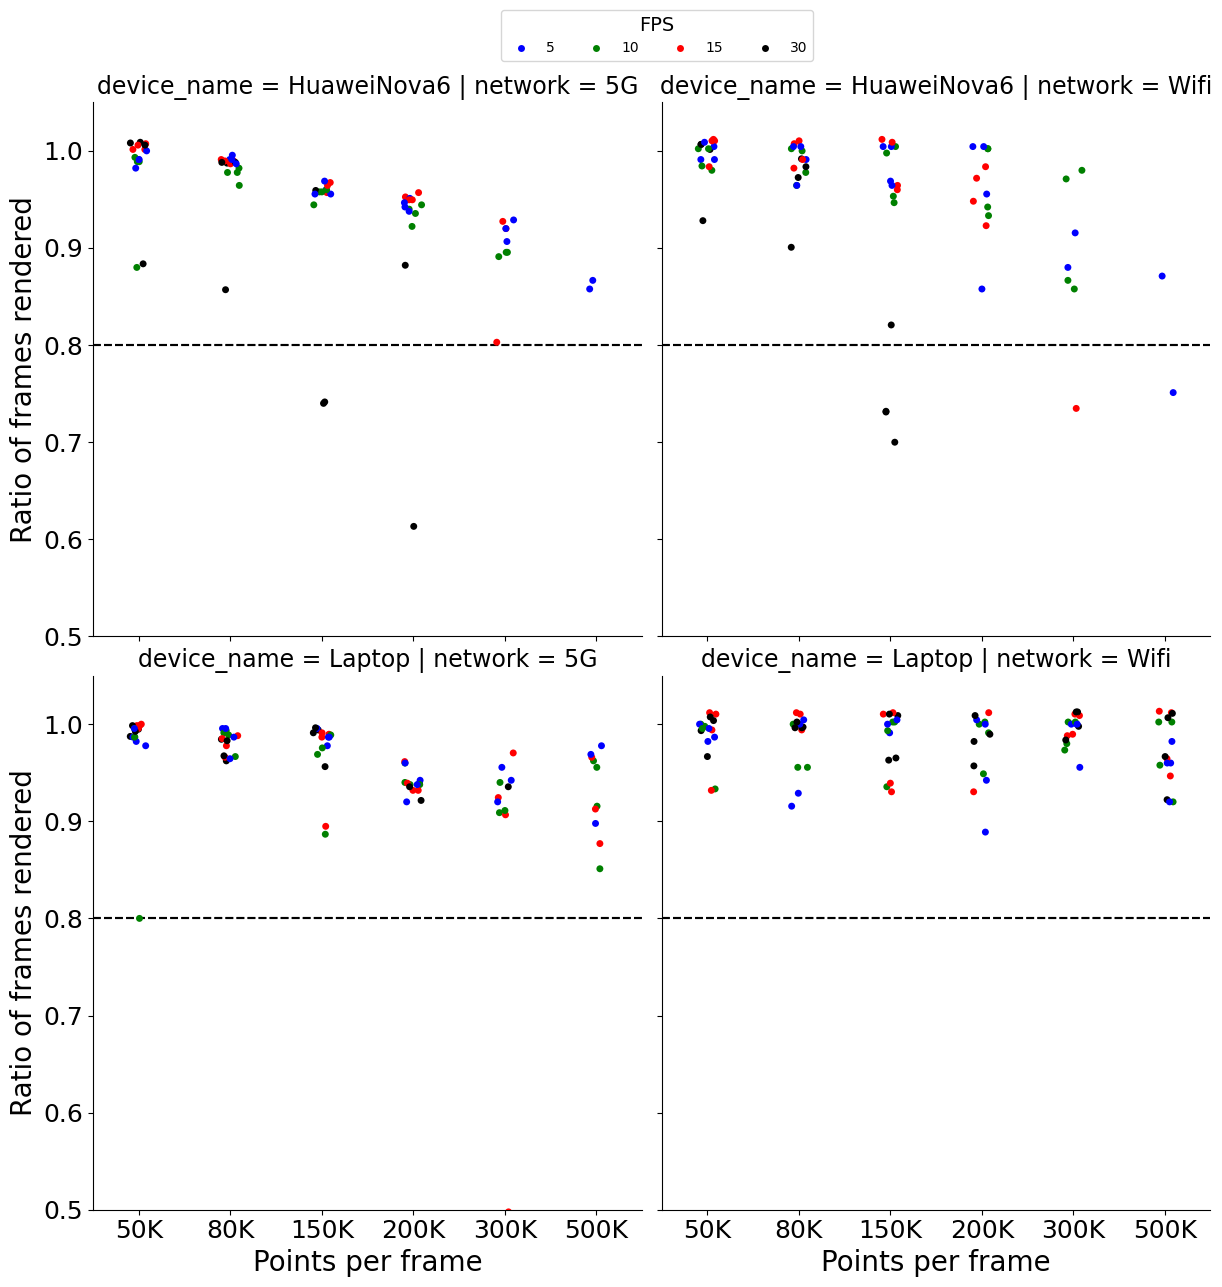

In [35]:
# PLot Ratio of frames delivered
color_palette = (['blue, green, red, black'])
p = sns.catplot(data=nframes, col='network', row='device_name',  y='ratio', x='points', hue='fps', hue_order=ordered_fps, legend_out=True, kind='strip', height=6, order=ordered_points, marker='o', palette=sns.color_palette(['blue', 'green', 'red', 'black']))
p.set(xlabel="Points per frame", ylabel="Ratio of frames rendered")

# Add a horizontal dashed line at y=0.09 for each subplot:
for ax in p.axes.flat:
    ax.axhline(0.8, color='black', linestyle='--')

# Adjust legend and y-limits:
sns.move_legend(
    p, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=True,
)
p.set(ylim=(0.5, 1.05))
p.legend.set_title("FPS", prop={'size': 14})

for ax in p.axes.flat:
    # facet title
    ax.title.set_fontsize(14)
    # axis labels
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.set_xlabel("Points per frame", fontsize=20)
    ax.set_ylabel("Ratio of frames rendered", fontsize=20)
    # tick labels (optional)
    ax.tick_params(axis='both', labelsize=18)
    # your line
    ax.axhline(0.8, color='black', linestyle='--')


p.set_titles(size=17) 
plt.show()




In [29]:
# Cut 45 playing seconds
df['playing_jitter'] = df.groupby('experiment_id')['pl_timestamp'].diff().fillna(0)
df['rel_playing'] = df.groupby('experiment_id').playing_jitter.cumsum()
df['bf1_in_timestamp'] = df['bf1_in_timestamp'].fillna(0)
df['bf1_in_timestamp'] = df['bf1_in_timestamp'].replace('', 0)
df['bf2_in_timestamp'] = df['bf2_in_timestamp'].replace('', 0)
df['bf1_out_timestamp'] = df['bf1_out_timestamp'].replace('', 0)
df['bf2_out_timestamp'] = df['bf2_out_timestamp'].replace('', 0)
df['buffering_time_2'] = df['bf2_out_timestamp'].astype('float') - df['bf2_in_timestamp'].astype('float')
df['buffering_time_1'] = df['bf1_out_timestamp'].astype('float') - df['bf1_out_timestamp'].astype('float')

# Metrics

In [30]:
df['instant_fps'] = 1000 / df.playing_jitter
df['instant_fps'] = df['instant_fps'].replace([inf, -inf], nan)

Plot of total frames rendered in each experiment, this plot is not present in the paper but helps to visualize problematic experiments. The number of frames expected to be rendered in each experiment are:
- 1350 frames for 30 fps (30 fps x 45 s)
- 675 frames for 15 fps
- 450 frames for 10 fps
- 225 frames for 5 fps

In [31]:
nframes_plot = nframes.copy()
nframes_plot = nframes_plot.sort_values('concurrency')
nframes_plot.rename(columns={'device_name': 'device'}, inplace=True)
nframes_plot['concurrency'] = nframes_plot['concurrency'].replace('Concurrent', 'True')
nframes_plot['concurrency'] = nframes_plot['concurrency'].replace('Isolated', 'False') 
nframes_plot = nframes_plot.sort_values('concurrency')
nframes_plot['device'] = nframes_plot['device'].replace('HuaweiNova6', 'Smartphone')

In [32]:
nframes_plot['exp_cond'] = nframes.network.str.cat(nframes.testbed).str.cat(nframes.transport).str.cat(nframes.concurrency.str[0:4].astype('str'))
nframes['exp_cond'] = nframes.network.str.cat(nframes.testbed).str.cat(nframes.transport).str.cat(nframes.concurrency.astype('str'))

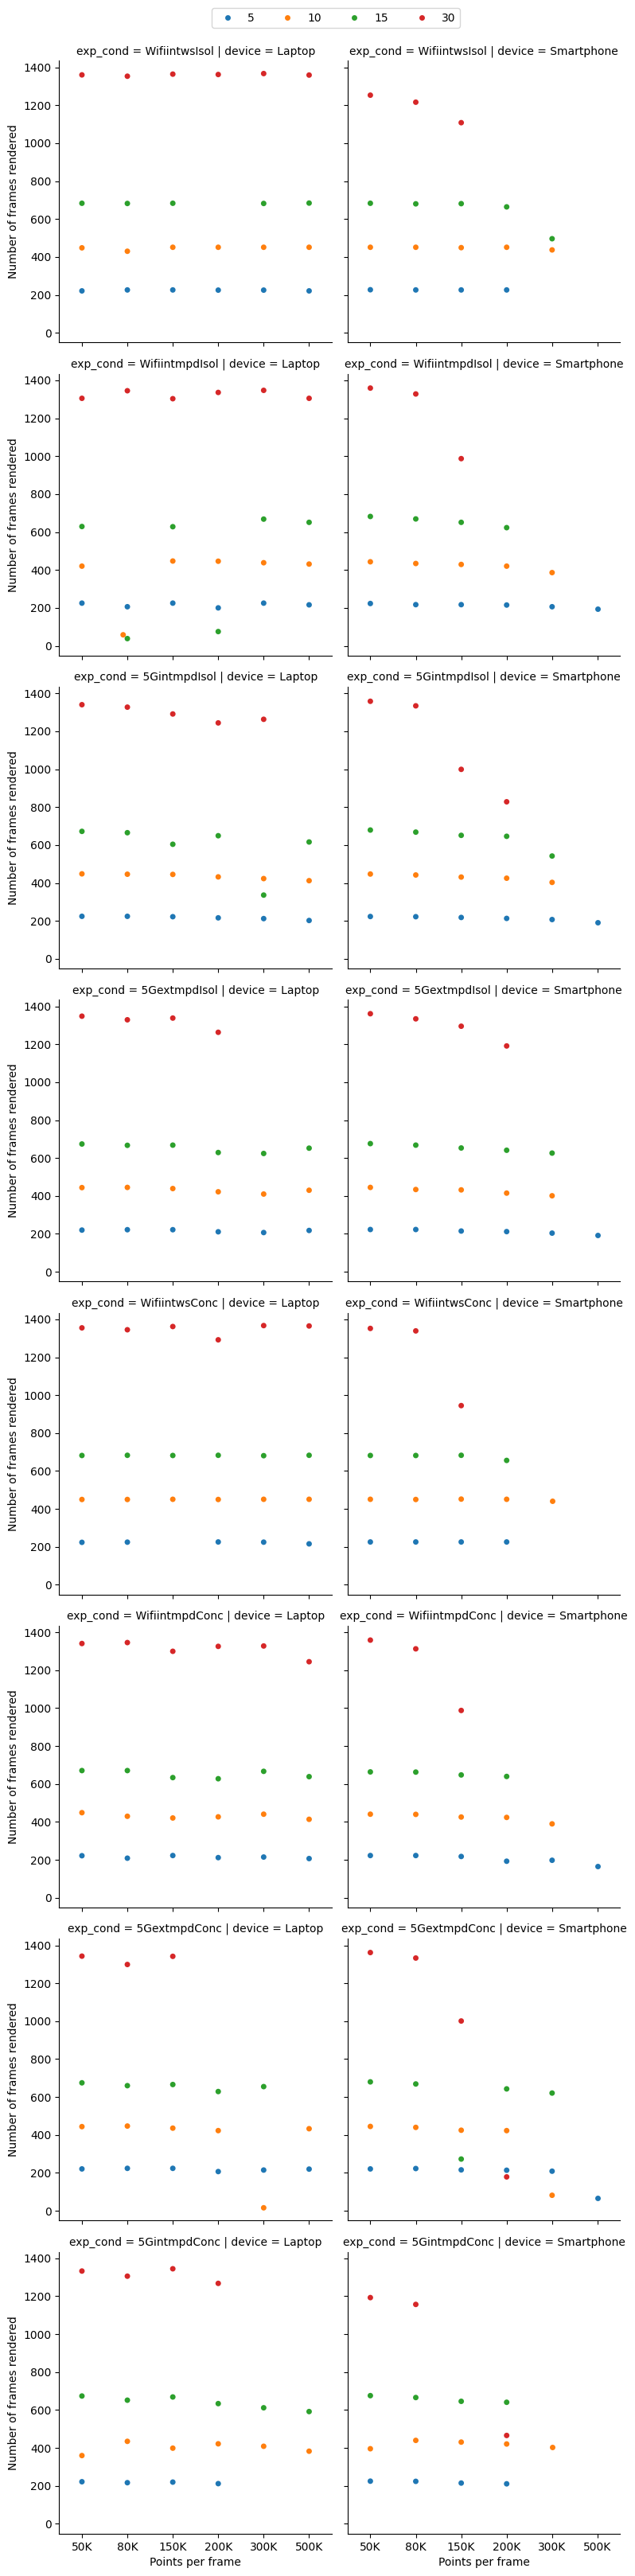

In [33]:
p = sns.catplot(data=nframes_plot, col='device', row='exp_cond', y='frame_number', x='points', hue='fps', hue_order=ordered_fps, order=ordered_points, legend_out=True, kind='swarm', height=4)
p.set(xlabel="Points per frame", ylabel="Number of frames rendered")
sns.move_legend(
    p, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=True,
)

#### Comparison between ratio of frames rendered considering concurrency for each device

It is possible to notice that concurrency penalises more devices with smaller capabilities

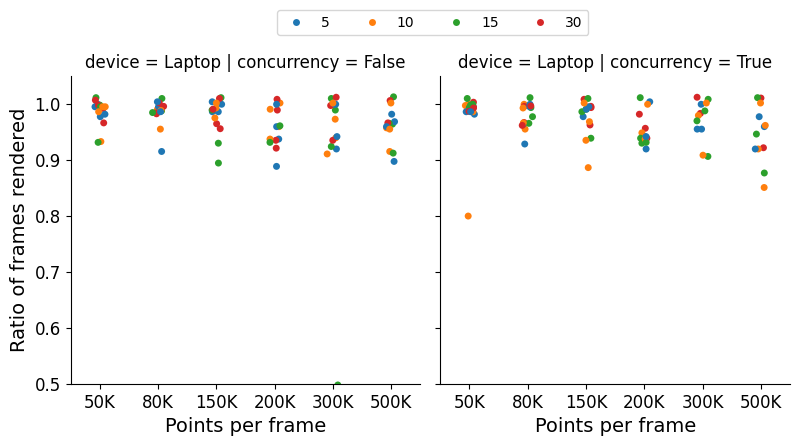

In [88]:
p = sns.catplot(
    data=nframes_plot[nframes_plot['device']=='Laptop'],
    row='device', col='concurrency',
    y='ratio', x='points', hue='fps', hue_order=ordered_fps,
    order=ordered_points, legend_out=True, kind='strip', height=4
)

# Axis labels (with fontsize) and legend
for ax in p.axes.flat:
    ax.set_xlabel("Points per frame", fontsize=14)
    ax.set_ylabel("Ratio of frames rendered", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)

sns.move_legend(
    p, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=True,
)

p.set(ylim=(0.5, 1.05))
p.set_titles(size=12)

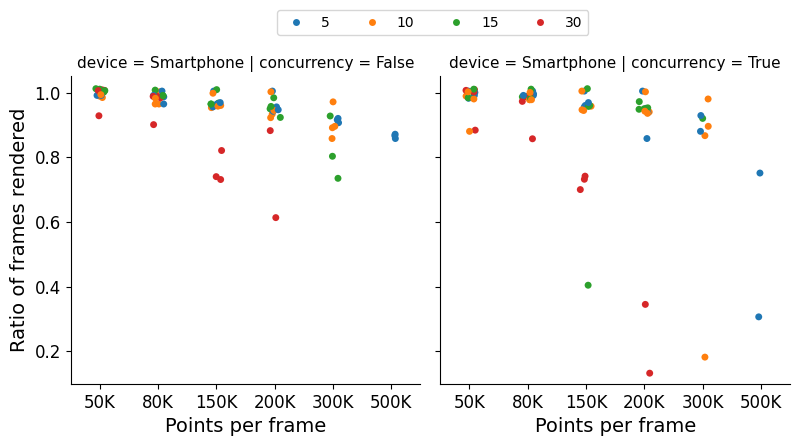

In [89]:
p = sns.catplot(data=nframes_plot[nframes_plot['device']=='Smartphone'], row='device', col='concurrency', y='ratio', x='points', hue='fps', hue_order=ordered_fps, order=ordered_points, legend_out=True, kind='strip', height=4)
# set axis labels with increased font size
for ax in p.axes.flat:
    ax.set_xlabel("Points per frame", fontsize=14)
    ax.set_ylabel("Ratio of frames rendered", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)

sns.move_legend(
    p, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=True,
)
p.set(ylim=(0.1, 1.05))
p.set_titles(size=11)

#### Experiments to discard

In [36]:
# experiments with < 80% frames delivered
experiments_to_discard = nframes[nframes['invalid']]['experiment_id']

# Performance comparison through each metric

In [37]:
df['points_per_sec'] = (df['points'].str[0:-1].astype(int) * df['fps'].astype('int')).astype('int')
df['points_per_sec'] = df['points_per_sec'].apply(lambda x: round(x/1000,2)).astype(str) + 'M'
point_cat = sorted(df['points_per_sec'].unique(), key=lambda x: float(x[:-1]))
df['points_per_sec'] = pd.Categorical(df['points_per_sec'], categories=point_cat)

## MPD vs WS

In [67]:
df_plot = df.sort_values(by=['transport'], ascending=[False]).copy()
df_plot = df_plot[(df_plot['concurrent'] == False) & (df_plot['network'] == 'Wifi') & (~df_plot['experiment_id'].isin(experiments_to_discard))]
df_plot.groupby('transport').experiment_id.unique().apply(len) # how many experiments per condition

df_plot['transport'] = df_plot['transport'].replace('mpd', 'MPD')
df_plot['transport'] = df_plot['transport'].replace('ws', 'WS')


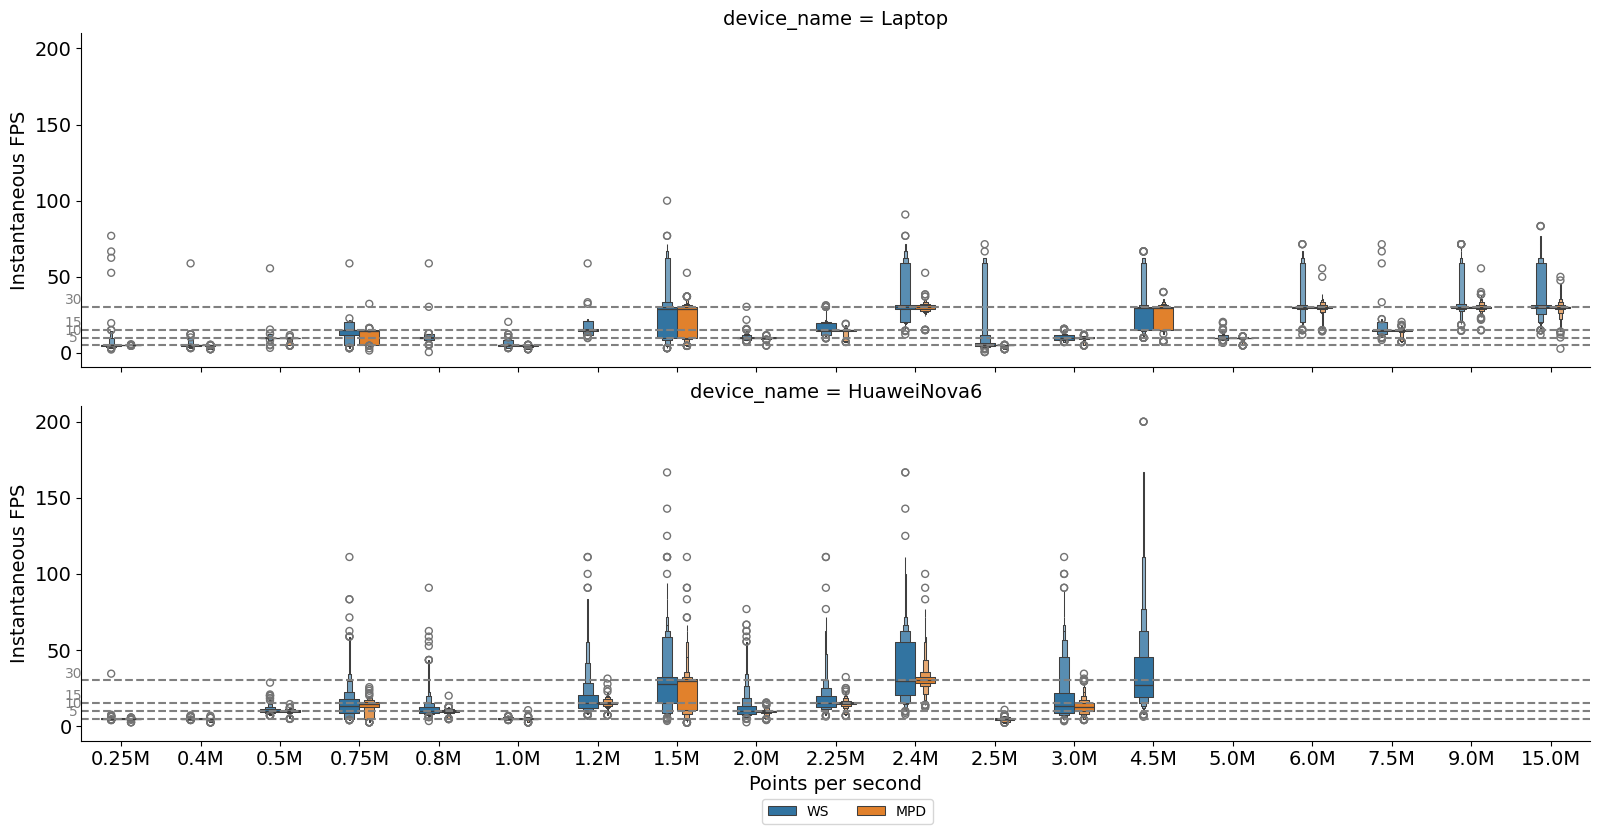

In [69]:
p = sns.catplot(data=df_plot, hue="transport", x="points_per_sec", y="instant_fps", row='device_name', kind="boxen", height=4, width=.5, aspect=4)
for ax in p.axes.flat:
    for fps_value in [5, 10, 15, 30]:
        ax.axhline(y=fps_value, color='gray', linestyle='--')
        ax.text(y=fps_value, x=-.6, s=str(fps_value), color='gray', ha='center', va='bottom')

sns.move_legend(
            p, "lower center",
            bbox_to_anchor=(.5, -0.04), ncol=5, title=None, frameon=True,
            )
for ax in p.axes.flat:
    ax.set_xlabel("Points per second", fontsize=14)
    ax.set_ylabel("Instantaneous FPS", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)

p.set_titles(size=14)

## Wifi vs 5G

In [70]:
df_plot = df.sort_values(by=['transport'], ascending=[False]).copy()
df_plot = df_plot[((df_plot['concurrent'] == False) & (df_plot['transport'] == 'mpd') & (~df_plot['experiment_id'].isin(experiments_to_discard)))]
df_plot.groupby('network').experiment_id.unique().apply(len) # how many experiments per condition


network
5G      82
Wifi    38
Name: experiment_id, dtype: int64

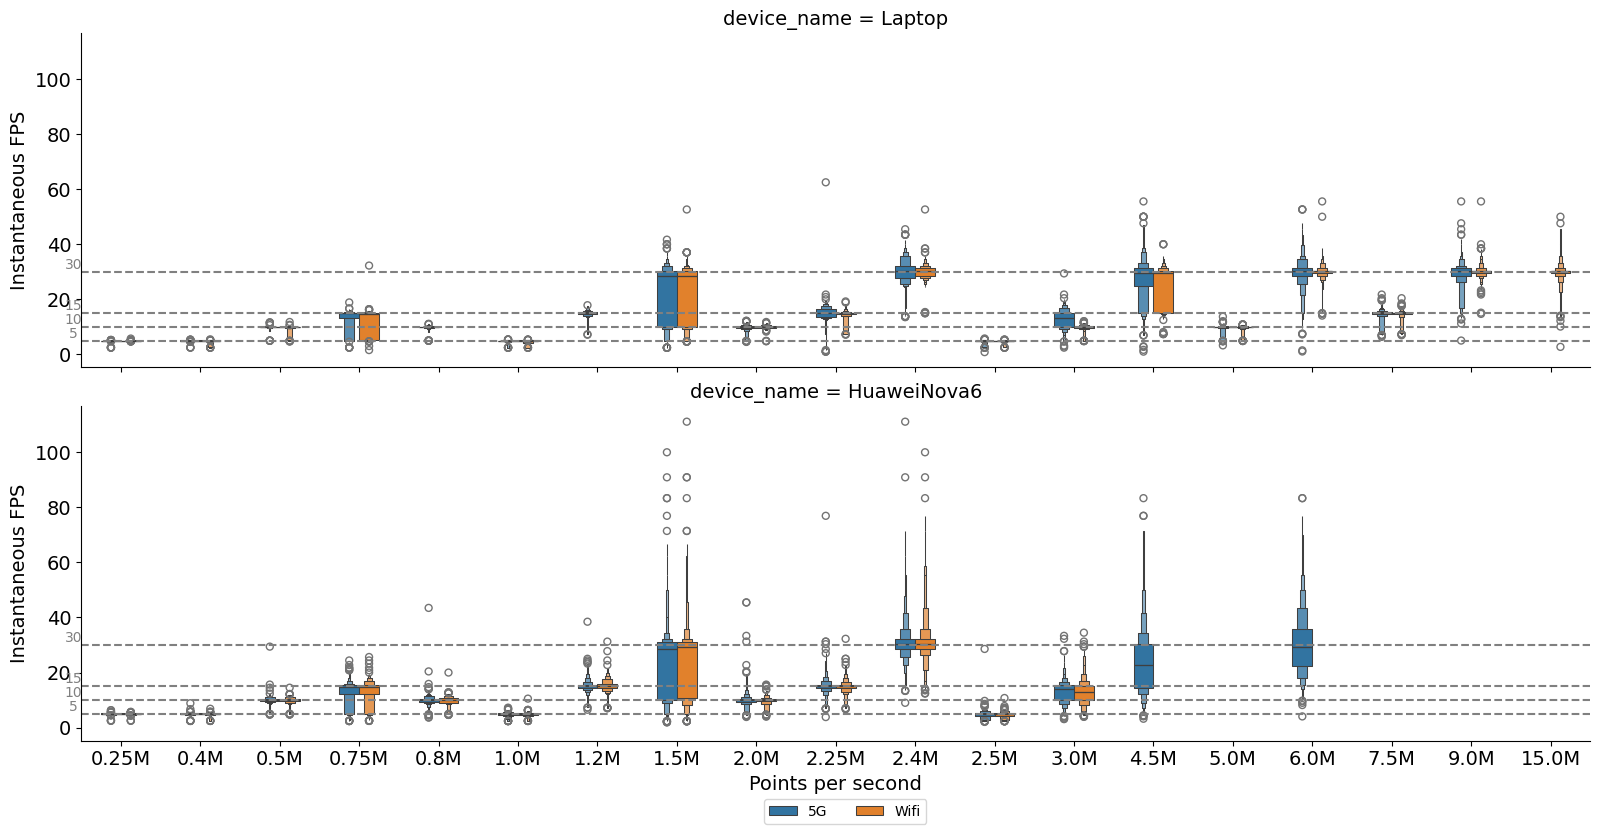

In [ ]:
p = sns.catplot(data=df_plot, hue="network", x="points_per_sec", y="instant_fps", row='device_name', kind="boxen", height=4, width=.5, aspect=4)
for ax in p.axes.flat:
    for fps_value in [5, 10, 15, 30]:
        ax.axhline(y=fps_value, color='gray', linestyle='--')
        ax.text(y=fps_value, x=-.6, s=str(fps_value), color='gray', ha='center', va='bottom')

sns.move_legend(
            p, "lower center",
            bbox_to_anchor=(.5, -0.04), ncol=5, title=None, frameon=True,
            )
for ax in p.axes.flat:
    ax.set_xlabel("Points per second", fontsize=14)
    ax.set_ylabel("Instantaneous FPS", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)

p.set_titles(size=14)

## 5G vs 5G Public

In [ ]:
df_plot = df.sort_values(by=['transport'], ascending=[False]).copy()
df_plot = df_plot[((df_plot['concurrent'] == False) & (df_plot['transport'] == 'mpd') & (df_plot['network'] == '5G'))]
df_plot.groupby('testbed').experiment_id.unique().apply(len) # how many experiments per condition

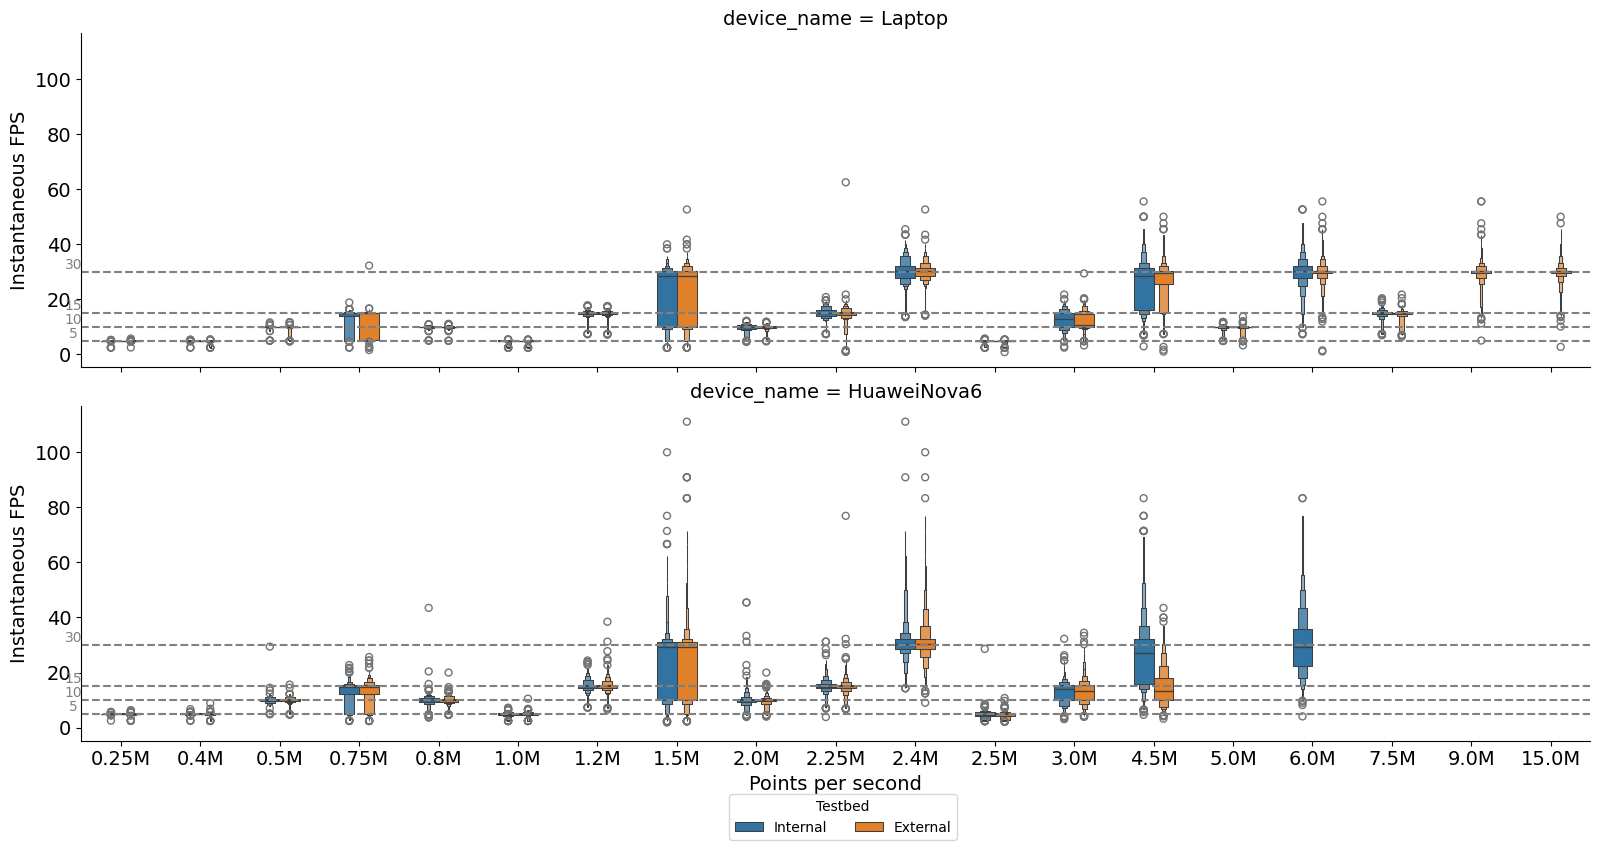

In [ ]:
p = sns.catplot(data=df_plot, hue="testbed", x="points_per_sec", y="instant_fps", row='device_name', kind="boxen", height=4, width=.5, aspect=4)
for ax in p.axes.flat:
    for fps_value in [5, 10, 15, 30]:
        ax.axhline(y=fps_value, color='gray', linestyle='--')
        ax.text(y=fps_value, x=-.6, s=str(fps_value), color='gray', ha='center', va='bottom')

sns.move_legend(
            p, "lower center",
            bbox_to_anchor=(.5, -0.06), ncol=5, title=None, frameon=True,
            )
for ax in p.axes.flat:
    ax.set_xlabel("Points per second", fontsize=14)
    ax.set_ylabel("Instantaneous FPS", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
p.legend.set_title("Testbed")
new_labels = ['Internal', 'External']
for t, l in zip(p._legend.texts, new_labels): t.set_text(l)
p.set_titles(size=14)

### Comparison of playing of a "good" experiment and a "bad" experiment

We took an experiment easy to process for a laptop and a smartphone (50K points @ 5 fps) and compared it to an experiment which more processing power is required ( 150K points @ 30 fps). It is clearly visible that the smartphone struggles more, making the buffer 2, between decoding and redering, not work smoothly and reducing the refresh rate of the screen (an indication of resource outage). The expected playing time is not according what is expected

In [78]:
# df_valid_tests = df[df['experiment_id'].isin(invalid_tests) == False].copy()
df_valid_tests = df.copy()
filter_devices = ['HuaweiNova6_Isolated_Wifi_mpd_int', 'HuaweiNova6_Concurrent_5G_mpd_ext', 'Laptop_Isolated_Wifi_mpd_int']

mask = df_valid_tests.experiment_group.apply(lambda x: x in filter_devices)
badmask = (df_valid_tests['points'] == '150K') &  (df_valid_tests['fps'] == "30")
goodmask = (df_valid_tests['points'] == '50K') & (df_valid_tests['fps'] == "5")

casedf = df_valid_tests[mask].copy()
casedf.loc[:,'frame_number'] = casedf.loc[:,'frame_number'].astype('int')
casedf.loc[:,'pl_timestamp'] = casedf.loc[:,'pl_timestamp'].astype('int')
casedf.loc[:,'frame_fps'] = casedf.loc[:,'frame_fps'].astype('float')
casedf['experiment_group'] = casedf['experiment_group'].astype('category')
casedf['experiment_group'] = casedf.experiment_group.cat.remove_unused_categories()

casedf['Case'] = 'Bad'
casedf.loc[goodmask,'Case'] = 'Good'

In [79]:
# Create Ideal Frame column which will be sequential
casedf['Ideal Frame'] = casedf.groupby('experiment_id', observed=False).cumcount() + 1

# Create expect_PL_time column which will be Ideal Frame / fps
casedf['expect_PL_time'] = casedf['Ideal Frame'] / casedf['fps'].astype(int) * 1000

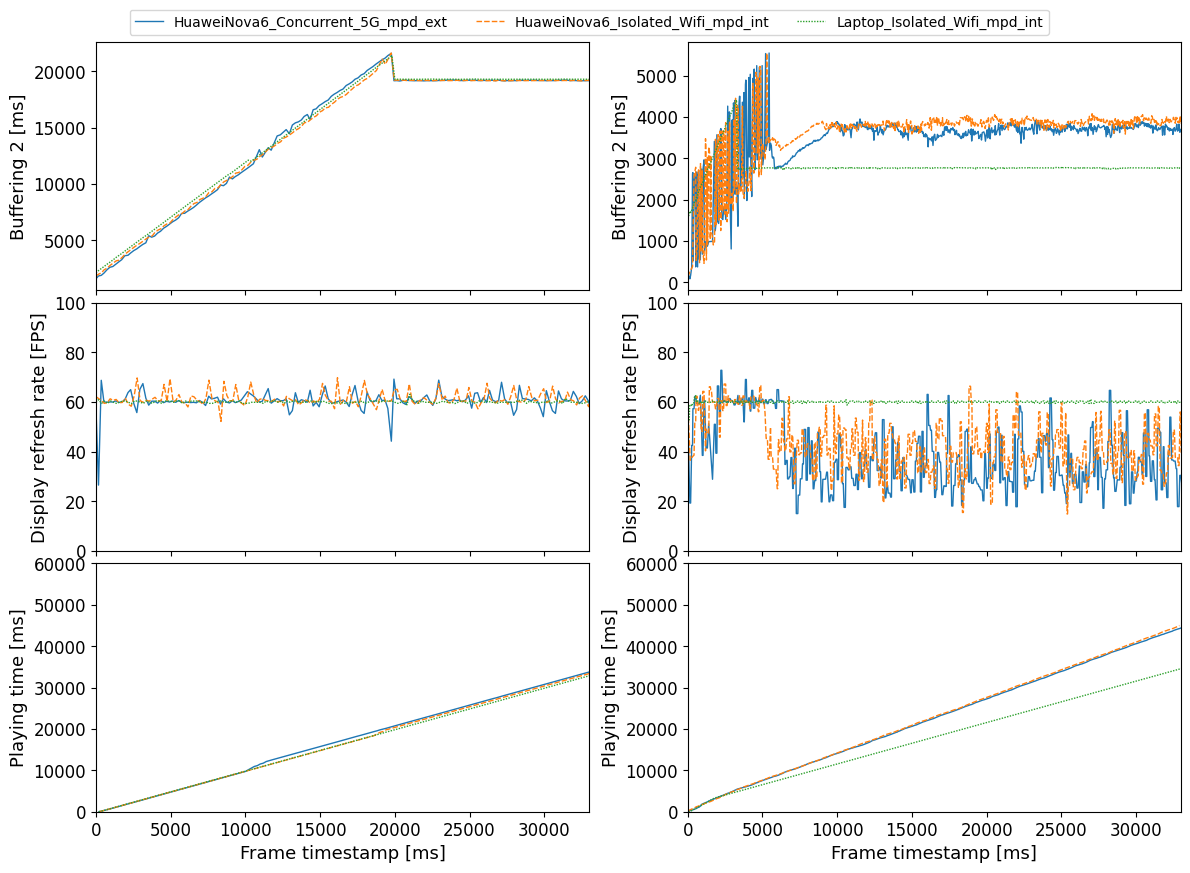

In [91]:
goodcasedf = casedf.loc[goodmask, :].copy()
goodcasedf['pl_timestamp'] = goodcasedf.groupby('experiment_group', observed=True)['pl_timestamp'].transform(lambda x: x - x.min())

badcasedf = casedf.loc[badmask, :].copy()
badcasedf['pl_timestamp'] = badcasedf.groupby('experiment_group', observed=True)['pl_timestamp'].transform(lambda x: x - x.min())
xrange = [0, 33000]

ig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
sns.lineplot(goodcasedf, y='buffering_time_2', x='pl_timestamp', hue='experiment_group', style='experiment_group', linewidth=1,  ax=axs[0][0], legend=True)
axs[0][0].set(ylabel="Buffering 2 [ms]", xlabel="", xticklabels=[], xlim=xrange)

sns.lineplot(badcasedf, y='buffering_time_2', x='pl_timestamp', hue='experiment_group', style='experiment_group', linewidth=1,  ax=axs[0][1], legend=False)
axs[0][1].set(ylabel="Buffering 2 [ms]", xlabel="", xticklabels=[], xlim=xrange)


sns.lineplot(goodcasedf, y='frame_fps', x='pl_timestamp', hue='experiment_group', style='experiment_group', linewidth=1, ax=axs[1][0], legend=False)
axs[1][0].set(ylabel="Display refresh rate [FPS]", xlabel="", xticklabels=[], xlim=xrange,ylim=[0,100])

sns.lineplot(badcasedf, y='frame_fps', x='pl_timestamp', hue='experiment_group', style='experiment_group', linewidth=1, ax=axs[1][1], legend=False)
axs[1][1].set(ylabel="Display refresh rate [FPS]", xlabel="", xticklabels=[], xlim=xrange, ylim=[0,100])

sns.lineplot(goodcasedf, y='pl_timestamp', x='expect_PL_time', hue='experiment_group', style='experiment_group', linewidth=1, ax=axs[2][0], legend=False)
axs[2][0].set(ylabel="Playing time [ms]", xlabel="Frame timestamp [ms]", xlim=xrange, ylim=[0,60000])

sns.lineplot(badcasedf, y='pl_timestamp', x='expect_PL_time', hue='experiment_group', style='experiment_group', linewidth=1, ax=axs[2][1], legend=False)
axs[2][1].set(ylabel="Playing time [ms]", xlabel="Frame timestamp [ms]", xlim=xrange, ylim=[0,60000])

# Increase fontsize for axis labels, tick labels and titles
for ax in axs.flat:
    ax.xaxis.label.set_size(13)
    ax.yaxis.label.set_size(13)
    ax.tick_params(axis='both', labelsize=12)
    ax.title.set_fontsize(13)
    # update legend text size if legend exists
    leg = ax.get_legend()
    if leg is not None:
        for text in leg.get_texts():
            text.set_fontsize(13)

sns.move_legend(axs[0][0], "lower center", bbox_to_anchor=(1, 1), ncol=5, title=None, frameon=True)
plt.subplots_adjust(wspace=0.2, hspace=0.05)